## NLP Class Final Project Read Data

In [1]:
import numpy as np
import pandas as pd
from gensim import corpora, models
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore

#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm

import re
import nltk
import os
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 600)

In [ ]:
#nltk.download('stopwords')

In [16]:
#!pip install gensim

In [22]:
#!pip install pyLDAvis

In [7]:
#!pip install nltk

#insights jobs and tasks will have major impact by AI
#provide recommendations on how it can be useful to automate tasks / jobs to improve employee productivity
#keywords: ChatGPT / ConversationalAI - look for them like this
#find topics - begin with - done with the cleaning - which news articles are talking about the important topics?
#disregard those news articles that are not relevant
#see which are the emerging technologies in this data through topic modeling
#sample data based on relevance of data
#search on website - find the keywords readily on a website (emerging technologies)
#talk about trends - date - how these keywords are performing over time (ChatGPT)
#ppt
#exec summary - cant tell what i have done - show what you found
#each topic
#sentimental analysis
#2 ways
#create own corpus
#or use pre-existing ones - 
#targeted sentiment to words like AI / entities
#200k news articles 
#run sentiment modeling (naive bayes) - find entities - get keyword extraction from the entities (through topic modeling)
#first ran LDA and then ran BERT on the overall
#what can you really first articles? Which tasks can be automated? 
#do you actually see emerging technology that will be able to automate task related to visual cortex?
#LLms are good at text summarization / extraction / text generation
#LLM cannot effectively drive a lawn
#what can you find in these artiles - is it really legal / office can effectively be automated? or in construction sector impossible to be automated?
#amazon / alibaba really good at package picking jobs in warehouses
#those machines are actually working - are we going to expect a similar breakthrough for physical moving devices in NLP space with generative AI?
#do you see specific trends in articles that will lead you to believe from Goldman Sachs are correct or incorrect based on how technologies develop?
#objective: identify which types of tasks and jobs are going to see biggest impact from AI
# executive summary - tell you what you found
# clean-up - article randoms - filtering (out of 200k - taking the articles away)
# sentiment analysis - explicity customized - if you open a text blob - apply it to technology articles - you will not get good sentiment - train your own model and find a model that was pretrained on a similar corpus
# sentiment over time - did it change or is it consistent? 16 / 17 months? sentiment might also change drastically
# entitiy organizations / people identification - in articles - why? find people say work at meta is going to be transformed
# targeted sentiment - if you finding the technology that says our RPA - dont tell sentiment of entire article but find sentiment with regard to RPA  
#not what you believe but what you find from text
#are we going to see a similar breakthrough
#ran topic 
#eliminate new lines / tabs / randoms of the web crawls - take out irrelevant text (use regex to take out) - make sure noise to text ratio is reasonable
#take out irrelevant articles
#what drove that successful ai initiatives? maturity of tech? was enough money poured? why certain industries are being transformed or not transformed? 
#what is constantly positioned as a failure
#failure - failure and then all of a sudden - it is a success - no one thought AI solutoin can code nearly as good as it can today
#think about how these new technologies emerging - LLMs came only after nov
#see any named entities mentioned? companies? gov institutions? government institutions - what can they do in creating policies? china - US - india? 
#sentiment - identify entities and then apply targeted sentiment!  what companies should invest into data science based on success stories? if you are healthcare / construction / police union - should you invest into it? electrician union? 
#what types of applications cannot be transformed based on today's technologies? failure - certain industries in common? projects in common?


#
#lora_config = LoraConfig(
 #r=16, #lora_2 = 4 in vishals #4 attention heads - 
 #lora_alpha=32, #16 in vishals
 #target_modules=["q", "v"],
 #lora_dropout=0.05,
 #bias="none",
 #task_type=TaskType.SEQ_2_SEQ_LM
)

#add_eos_token - sequence number at the end (for the end of the sequence)
#peft - library in hugging face
#




In [2]:
!pip install pyarrow    

In [30]:
%%time

df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

CPU times: user 6.72 s, sys: 4.08 s, total: 10.8 s
Wall time: 17.6 s


(200332, 5)

In [68]:
#save this dataframe so i do not have to keep reading it in
#df_news_final_project.to_parquet('news_final_project.parquet', engine='pyarrow')
#where does it save?
#!ls


In [3]:
#!pip install pandarallel

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16677 sha256=ca37cea731566327e0f32288c83f74dd8b0e853116d8e517d4e5229d484f6d58
  Stored in directory: /home/jupyter/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [16]:
import pandarallel
from pandarallel import pandarallel

In [17]:
import multiprocessing

num_processors = multiprocessing.cpu_count()

# Now you can use num_processors in your code.


In [18]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [28]:
# expand length of column width
pd.set_option('display.max_colwidth', 1000)

In [31]:
df_news_final_project.head()

,url,date,language,title,text
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, March 18, 2021\nPhoto taken on July 1, 2019, shows a sign for electronic toll collection (ETC) newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. Some urban areas of the city started to use ETC system for roadside parking spaces since July 1, 2019. (People’s Daily Online/Li Wenming)\n\n\tThanks to the application of an artificial intelligence (AI)-empowered roadside electronic toll collection (ETC) system, China’s capital city Beijing has seen significant im..."
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in corporate paid leave policies\n\nNews Parliament\n\nGet the Real Story\n\n \nNews\nTechnology\nServices\nHealthcare\nWorld\nBusiness\nEntertainment\n \n\nWorld \n\n\n \t\t\tChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot \t\t\n\n\n February 27, 2020February 27, 2020\nadmin\t\t\t\t\t\n\n\n 0 Comments\n\n\n Author Recent Posts admin Latest posts by admin (see all) Mansplaining in conferences: How can we get him to forestall? - February 27, 20..."
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek","\n\nForget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nEMP Handbook\nSubscribe\nAdvertise\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection\n▸ Computer/Embedded Technology\n▸ Design Automation\n▸ DSP, Micros & Memory\n▸ Electronics Technology\n▸ Enclosures, Racks, Cabinets & Panel Products\n▸ Events\n▸ Interconnection\n▸ Manufacturing / Production Technology, Hardware & Services\n▸ News\n▸ Opto-Electronics\n▸ Passive Components\n▸ Power Electronics / Power Management\n▸ Programmable Logic\n▸ Smart Home Automation\n▸ Switches, Relays & Keypads\n▸ Telecoms, Datacoms, Wireless, IoT\n▸ Test & Measurement\n \n\nCategories\n\nEditor's Choice\n\n\nMultimedia, Videos\n\n\nAnalogue, Mixed Signal, LSI\n\n\nCircuit & System Protection\n\n\nComputer/Embedded Technology\n\n\nDesign Automation\n\n\nDSP, Micros & ..."
3,http://www.homeoffice.consumerelectronicsnet.com/strategy-analytics-71-of-smartphones-sold-globally-in-2021-will-be-ai-powered/,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net,"\n\nStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net\n 

In [32]:
# value counts of language
df_news_final_project['language'].value_counts()

en    200332
Name: language, dtype: int64

In [19]:
# around 60k news articles with the same titles
#around 1500 news articles with the same text - removed this 


In [33]:
#decided to only drop the same text because it may be the same articles
#im going to later analyze news articles with same titles to show importance! this will be important to see trends
df_news_final_project = df_news_final_project.drop_duplicates(subset=['text'])
df_news_final_project.shape

(198564, 5)

In [8]:
# take a sample of 1000 rows
#df_news_final_project_sample = df_news_final_project.sample(n=1000, random_state=1)

In [34]:
# reset index
df_news_final_project.reset_index(drop=True, inplace=True)


In [37]:
# Clean-up the noise, by eliminating newlines, tabs, remnants of web crawls, and other irrelevant text

import re
df_news_final_project['content_clean'] = df_news_final_project['text'].str.replace('\n', ' ') 
df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('\t', ' ')
df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('\r', ' ')
df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('<!--.*?-->', ' ')
df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('<script.*?>.*?</script>', ' ')
df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('<.*?>', ' ')
df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('http\S+|www.\S+', ' ')
df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('[^a-zA-Z0-9\s]', ' ')
df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('\s+', ' ')
df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('^\s+|\s+$', ' ')



/var/tmp/ipykernel_11314/899981166.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('<!--.*?-->', ' ')
/var/tmp/ipykernel_11314/899981166.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('<script.*?>.*?</script>', ' ')
/var/tmp/ipykernel_11314/899981166.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('<.*?>', ' ')
/var/tmp/ipykernel_11314/899981166.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df_news_final_project['content_clean'] = df_news_final_project['content_clean'].str.replace('http\S+|www.\S+',

In [39]:
import nltk
import string
stopwords = set(nltk.corpus.stopwords.words('english'))

df_news_final_project['clean_title'] = df_news_final_project['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df_news_final_project['clean_title'] = df_news_final_project['clean_title'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df_news_final_project['content_clean'] = df_news_final_project['content_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df_news_final_project['content_clean'] = df_news_final_project['content_clean'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [51]:
import nltk
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))  # define stopwords

def clean(string):
    
    url_pattern = r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'
    mention_pattern = r'[\s]*@[\w]+'
    hashtag_pattern = r'[\s]*#[\w]+'
    copyright_pattern = r"©.*"
    string_fixed = re.sub(url_pattern, "", string)
    string_fixed = re.sub(hashtag_pattern, "", string_fixed)
    string_fixed = re.sub(mention_pattern, "", string_fixed)
    string_fixed = re.sub(copyright_pattern, "", string_fixed)  # Remove everything after "©"
    string_fixed = string_fixed.replace('\n', ' ')
    
    # Convert to lower case and remove stop words without tokenization
    words = string_fixed.split()  # split string into words
    words = [word.lower() for word in words if word.lower() not in stopwords and word.isalpha()]
    
    return " ".join(words)

# Applying the function to the dataframe
df_news_final_project['cleaned_text'] = df_news_final_project['content_clean'].apply(clean)


In [ ]:
df_news_final_project['clean_title'] = df_news_final_project['clean_title'].apply(clean)


In [42]:
ai_terms = ["Artificial Intelligence", "Machine Learning", "Deep Learning", "Neural Network", "Natural Language Processing", "Supervised Learning", "Unsupervised Learning", "Reinforcement Learning", "Generative Adversarial Networks", "Convolutional Neural Networks", "Recurrent Neural Networks", "Transfer Learning", "Data Mining", "Big Data", "Algorithm","large language models","llms","robotics","drug","discovery","job","Chatbots", "Robotic Process Automation", "Computer Vision", "Image Recognition", "Speech Recognition", "Text Analytics", "Sentiment Analysis", "Autonomous Vehicles", "Internet of Things", "Edge Computing", "Quantum Computing"]


In [43]:
#filter dataframe 
ai_terms = '|'.join(ai_terms)


In [44]:
ai_terms

'Artificial Intelligence|Machine Learning|Deep Learning|Neural Network|Natural Language Processing|Supervised Learning|Unsupervised Learning|Reinforcement Learning|Generative Adversarial Networks|Convolutional Neural Networks|Recurrent Neural Networks|Transfer Learning|Data Mining|Big Data|Algorithm|large language models|llms|robotics|drug|discovery|job|Chatbots|Robotic Process Automation|Computer Vision|Image Recognition|Speech Recognition|Text Analytics|Sentiment Analysis|Autonomous Vehicles|Internet of Things|Edge Computing|Quantum Computing'

In [62]:
df_filtered = df_news_final_project[df_news_final_project['cleaned_text'].str.contains(ai_terms, case=False, na=False)]


In [63]:
df_filtered.shape

(176867, 8)

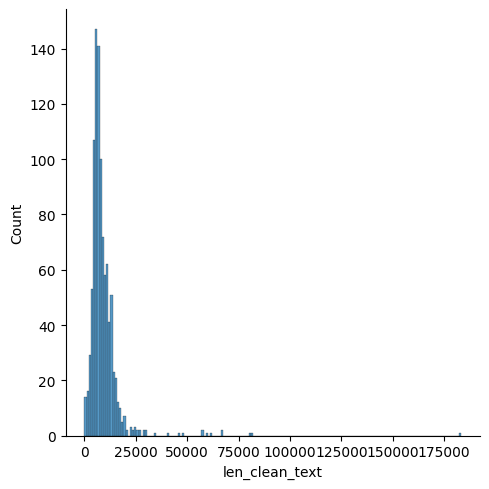

In [76]:
# #before cleaning - DONT RUN THIS
# import seaborn as sns
# df_news_final_project_sample = df_news_final_project_sample.dropna()
# df_news_final_project_sample = df_news_final_project_sample.drop_duplicates(subset=['cleaned_text'])
# df_news_final_project_sample['len_clean_text'] = df_news_final_project_sample['cleaned_text'].apply(lambda x: len(x))
# sns.displot(data=df_news_final_project_sample,x='len_clean_text')


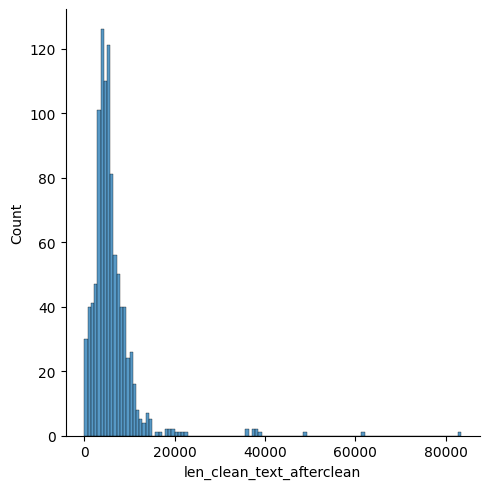

In [80]:
#after cleaning
import seaborn as sns
df_news_final_project_sample = df_news_final_project_sample.dropna()
df_news_final_project_sample = df_news_final_project_sample.drop_duplicates(subset=['cleaned_text'])
df_news_final_project_sample['len_clean_text_afterclean'] = df_news_final_project_sample['cleaned_text'].apply(lambda x: len(x))
sns.displot(data=df_news_final_project_sample,x='len_clean_text_afterclean')


In [32]:
news_df = df_news_final_project

In [33]:
news_df.shape

(198564, 8)

In [34]:
tokenizer = nltk.tokenize.TweetTokenizer()

# This creates a list of all tokenized sentences
tokenized_sentences = news_df['cleaned_text'].apply(tokenizer.tokenize).tolist()

# This will flatten the list of lists into a single list
words = [word for sublist in tokenized_sentences for word in sublist]


In [35]:
bgs = nltk.bigrams(words)
targeted_bgs = ['machine','learning','ai','artificial','intelligence','natural','language','processing','chatgpt','data','science','python','r','c','analytics','ml','nlp','generative','legal','office','law','llm','large','language','model','management','business','finance','financial','industry','healthcare','production','service','manufacture','productivity','job','GenAI']
bgs = [b for b in bgs if (b[0] in targeted_bgs) or (b[1] in targeted_bgs)]
bigrams_freq = nltk.FreqDist(bgs)
bigrams_freq_df = pd.DataFrame(bigrams_freq.most_common(),columns=['Word', 'Frequency'])
bigrams_freq_df.head(n=50)


,Word,Frequency
0,"(artificial, intelligence)",621509
1,"(machine, learning)",239444
2,"(intelligence, ai)",126521
3,"(data, science)",76450
4,"(global, artificial)",65781
5,"(generative, ai)",44736
6,"(financial, services)",43689
7,"(ai, powered)",41162
8,"(ai, technology)",39027
9,"(ai, market)",35826


In [141]:
# assuming 'words' is a list of tokenized words from your document
fourgrams = nltk.ngrams(words, 4)

targeted_fourgrams = [
    'machine', 'learning', 'ai', 'artificial', 'intelligence', 'natural', 
    'language', 'processing', 'chatgpt', 'data', 'science', 'python', 'r', 
    'c', 'analytics', 'ml', 'nlp', 'generative', 'legal', 'office', 'law', 
    'llm', 'large', 'language', 'model', 'management', 'business', 'finance', 
    'financial', 'industry', 'healthcare', 'production', 'service', 
    'manufacture', 'productivity', 'job', 'GenAI'
]

fourgrams = [
    b for b in fourgrams 
    if (b[0] in targeted_fourgrams) or (b[1] in targeted_fourgrams) 
    or (b[2] in targeted_fourgrams) or (b[3] in targeted_fourgrams)
]

fourgrams_dist = nltk.FreqDist(fourgrams)
fourgrams_dist_df = pd.DataFrame(fourgrams_dist.most_common(), columns=['Word', 'Frequency'])
fourgrams_dist_df.head(n=50)


,Word,Frequency
0,"(global, artificial, intelligence, ai)",102
1,"(artificial, intelligence, ai, service)",86
2,"(call, center, ai, market)",73
3,"(artificial, intelligence, energy, market)",71
4,"(intelligence, energy, market, market)",62
5,"(artificial, intelligencebased, security, market)",56
6,"(ai, computer, vision, market)",53
7,"(artificial, intelligence, software, market)",53
8,"(cyber, data, science, market)",52
9,"(automotive, artificial, intelligence, software)",47


In [37]:
#Running FinancialBert for sentiment analysis

In [9]:
#!pip install -q transformers

In [10]:
# created on GCP Vertex AI Notebook using  `Python 3 (CUDA Toolkit 11.0)` environment
# using n1-standard-4 (4 vCPUS, 15 GB RAM) compute w/ 1 NVIDIA T4 GPU

# dependencies
#!pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116
#%pip install transformers datasets evaluate rouge-score nltk py7zr
#nltk.download("punkt")

# note: installing an older version of pytorch so that cuda versions match
# note: py7zr is needed for the `samsum` dataset, may or may not be needed for other datasets

In [65]:
#!pip install tensorflow

In [11]:
from __future__ import absolute_import, division, print_function

import collections

import math
import glob
import json

import numpy as np
import torch
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset

from transformers import WEIGHTS_NAME, BertConfig, BertForQuestionAnswering, BertTokenizer
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

from transformers import logging
import tensorflow as tf

logging.set_verbosity_error()
logging.get_verbosity()

# from utils import (get_answer, input_to_squad_example,
#                    squad_examples_to_features, to_list)

2023-05-18 16:36:40.354738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 16:36:45.867895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-18 16:36:45.868975: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

40

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

sentences = ["Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales.",  
             "Bids or offers include at least 1,000 shares and the value of the shares must correspond to at least EUR 4,000.", 
             "Raute reported a loss per share of EUR 0.86 for the first half of 2009 , against EPS of EUR 0.74 in the corresponding period of 2008.", 
             ]
results = nlp(sentences)
print(results)

[{'label': 'positive', 'score': 0.9998133778572083},
 {'label': 'neutral', 'score': 0.9997822642326355},
 {'label': 'negative', 'score': 0.9877365231513977}]



[{'label': 'positive', 'score': 0.9998133778572083}, {'label': 'neutral', 'score': 0.9997822642326355}, {'label': 'negative', 'score': 0.9877365231513977}]


/opt/conda/lib/python3.7/site-packages/transformers/models/open_llama/modeling_open_llama.py:43: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  "Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers\npip install xformers."


[{'label': 'positive', 'score': 0.9998133778572083},
 {'label': 'neutral', 'score': 0.9997822642326355},
 {'label': 'negative', 'score': 0.9877365231513977}]

In [12]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Apply sentiment analysis on the 'cleaned_text' column
df_filtered['sentiment'] = df_filtered['cleaned_text'].apply(lambda x: nlp(x)[0]['label'])

# If you want to store the sentiment scores as well, you can do it like this
df_filtered['sentiment_score'] = df_filtered['cleaned_text'].apply(lambda x: nlp(x)[0]['score'])


NameError: name 'df_filtered' is not defined

In [7]:
%%time

df_filtered_sample = pd.read_parquet('df_filtered_sample.parquet', engine='pyarrow')
df_filtered_sample.shape

CPU times: total: 703 ms
Wall time: 2.11 s


(1000, 10)

In [9]:
df_filtered_sample.head()

,url,date,language,title,text,content_clean,clean_title,cleaned_text,sentiment,confidence_score
96091,http://www.hardware.broadcastnewsroom.com/2020/04/24/aws-announces-general-availability-of-amazon-augmented-artificial-intelligence-a2i/?utm_source=rss&utm_medium=rss&utm_campaign=aws-announces-general-availability-of-amazon-augmented-artificial-intelligence-a2i,2020-04-24,en,AWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I) | | Broadcast Newsroom,\n\nAWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I) | | Broadcast Newsroom\n \n\nSkip to content\nBroadcast Newsroom\n\nNews & Information for Broadcast Professionals\n\nPrimary Menu\n\nSearch for:\n \nHome2020April24AWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I) \n\n \n\n \n News\n \n \nAWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I)\n\n\nBy\n\n BN Staff \n\n\n 3 hours ago \n\...,AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I Broadcast Newsroom Skip content Broadcast Newsroom News Information Broadcast Professionals Primary Menu Search Home2020April24AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I News AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I By BN Staff 3 hours ago Amazon A2I makes easier developers build manage workflows validate machine learning predictions human reviewers National Health Service NHS UK T Mobile Deloitte among customers partners using Amazon A...,AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I Broadcast Newsroom,aws announces general availability amazon augmented artificial intelligence broadcast newsroom skip content broadcast newsroom news information broadcast professionals primary menu search announces general availability amazon augmented artificial intelligence news aws announces general availability amazon augmented artificial intelligence bn staff hours ago amazon makes easier developers build manage workflows validate machine learning predictions human reviewers national health service nhs uk mobile deloitte among customers partners using amazon seattle business wire today amazon web serv...,neutral,0.902667
91201,https://businessday.ng/news/article/nigerians-query-chatgpt-on-how-to-win-tinubu-others/,2023-01-15,en,"Nigerians query ChatGPT on 'How to win Tinubu', others - Businessday NG","\n\nNigerians query ChatGPT on 'How to win Tinubu', others - Businessday NG\n\n\r\n \n\n \n\n \n\n \n\nNews\nAhmed Bola Tinubu,BDrecent\nBusinessDay\n\nHome\nBig Story\nNews\n\nWorld\n\nAfrica\n\n\nLegal Business\nSports.\nEducation\n\n\nNigeriaDecides2023\nCompanies\nEconomy\n\nAgriculture\nAviation\nBanking\nMaritime\nReal Estate\nTransportation\nResearch post\n\n\nTechnology\nEnergy\n\nRenewables\nPower\nOil & Gas\n\n\nInterview\nCommentary\n\nColumnists\nOpinion\nEditorial\n\n\nBD Weekender\nCartoon\nData Analytics\n\nMarket Data\nGovernance Data\n\n\nApp\n\nDownload Andriod App...",Nigerians query ChatGPT How win Tinubu others Businessday NG News Ahmed Bola Tinubu BDrecent BusinessDay Home Big Story News World Africa Legal Business Sports Education NigeriaDecides2023 Companies Economy Agriculture Aviation Banking Maritime Real Estate Transportation Research post Technology Energy Renewables Power Oil Gas Interview Commentary Columnists Opinion Editorial BD Weekender Cartoon Data Analytics Market Data Governance Data App Download Andriod App Download IOS Conferences Login My Account Subscribe Logout Sunday January 15 2023 Businessday Ng Home Big Story News World Afric...,Nigerians query ChatGPT How win Tinubu others Businessday NG,nigerians query chatgpt win tinubu others businessday ng news ahmed bola tinubu bdrecent businessday home big story news world africa legal business sports education companies economy agriculture aviation banking maritime real estate transportation research post

In [64]:
df_filtered_sample = df_filtered.sample(n=1000, random_state=1)

In [65]:
df_filtered_sample.shape

(1000, 8)

In [66]:
# from transformers import BertTokenizer, BertForSequenceClassification
# import torch

# # Load pretrained model and tokenizer
# model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis", num_labels=3)
# tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

# # Define the maximum length for the text chunks. BERT typically works with a max_length of 512.
# max_length = 512

# # Function to apply sentiment analysis and manage text length
# def get_sentiment_and_score(text):
#     # Tokenize the text
#     inputs = tokenizer(text, truncation=True, padding='longest', max_length=max_length, return_tensors='pt')
    
#     # Get the model's output
#     output = model(**inputs)

#     # Get the sentiment
#     sentiment = output.logits.argmax(dim=1).item()

#     # Convert logits to probabilities
#     probabilities = torch.nn.functional.softmax(output.logits, dim=-1)

#     # Get the confidence score
#     confidence_score = probabilities.max(dim=-1).values.item()

#     # Convert the sentiment label from integer to string
#     if sentiment == 0:
#         sentiment = 'negative'
#     elif sentiment == 1:
#         sentiment = 'neutral'
#     else:
#         sentiment = 'positive'

#     return sentiment, confidence_score

# # Apply the function to the 'cleaned_text' column
# df_filtered_sample['sentiment'], df_filtered_sample['confidence_score'] = zip(*df_filtered_sample['cleaned_text'].map(get_sentiment_and_score))


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load pretrained model and tokenizer
model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis", num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

# Define the maximum length for the text chunks. BERT typically works with a max_length of 512.
max_length = 512

# Function to apply sentiment analysis and manage text length
def get_sentiment_and_score(text):
    # Tokenize the text
    inputs = tokenizer(text, truncation=True, padding='longest', max_length=max_length, return_tensors='pt')
    
    # Get the model's output
    output = model(**inputs)

    # Get the sentiment
    sentiment = output.logits.argmax(dim=1).item()

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(output.logits, dim=-1)

    # Get the confidence score
    confidence_score = probabilities.max(dim=-1).values.item()

    # Convert the sentiment label from integer to string
    if sentiment == 0:
        sentiment = 'negative'
    elif sentiment == 1:
        sentiment = 'neutral'
    else:
        sentiment = 'positive'

    return sentiment, confidence_score

# Apply the function to the 'cleaned_text' column
df_filtered_sample['sentiment'], df_filtered_sample['confidence_score'] = zip(*df_filtered_sample['cleaned_text'].map(get_sentiment_and_score))


In [69]:
df_filtered_sample.to_parquet('df_filtered_sample.parquet', engine='pyarrow')


In [ ]:
#read df_filtered_sample parquet 
df_filtered_sample = pd.read_parquet('df_filtered_sample.parquet', engine='pyarrow')

In [10]:
df_filtered_sample

,url,date,language,title,text,content_clean,clean_title,cleaned_text,sentiment,confidence_score
96091,http://www.hardware.broadcastnewsroom.com/2020/04/24/aws-announces-general-availability-of-amazon-augmented-artificial-intelligence-a2i/?utm_source=rss&utm_medium=rss&utm_campaign=aws-announces-general-availability-of-amazon-augmented-artificial-intelligence-a2i,2020-04-24,en,AWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I) | | Broadcast Newsroom,\n\nAWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I) | | Broadcast Newsroom\n \n\nSkip to content\nBroadcast Newsroom\n\nNews & Information for Broadcast Professionals\n\nPrimary Menu\n\nSearch for:\n \nHome2020April24AWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I) \n\n \n\n \n News\n \n \nAWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I)\n\n\nBy\n\n BN Staff \n\n\n 3 hours ago \n\...,AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I Broadcast Newsroom Skip content Broadcast Newsroom News Information Broadcast Professionals Primary Menu Search Home2020April24AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I News AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I By BN Staff 3 hours ago Amazon A2I makes easier developers build manage workflows validate machine learning predictions human reviewers National Health Service NHS UK T Mobile Deloitte among customers partners using Amazon A...,AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I Broadcast Newsroom,aws announces general availability amazon augmented artificial intelligence broadcast newsroom skip content broadcast newsroom news information broadcast professionals primary menu search announces general availability amazon augmented artificial intelligence news aws announces general availability amazon augmented artificial intelligence bn staff hours ago amazon makes easier developers build manage workflows validate machine learning predictions human reviewers national health service nhs uk mobile deloitte among customers partners using amazon seattle business wire today amazon web serv...,neutral,0.902667
91201,https://businessday.ng/news/article/nigerians-query-chatgpt-on-how-to-win-tinubu-others/,2023-01-15,en,"Nigerians query ChatGPT on 'How to win Tinubu', others - Businessday NG","\n\nNigerians query ChatGPT on 'How to win Tinubu', others - Businessday NG\n\n\r\n \n\n \n\n \n\n \n\nNews\nAhmed Bola Tinubu,BDrecent\nBusinessDay\n\nHome\nBig Story\nNews\n\nWorld\n\nAfrica\n\n\nLegal Business\nSports.\nEducation\n\n\nNigeriaDecides2023\nCompanies\nEconomy\n\nAgriculture\nAviation\nBanking\nMaritime\nReal Estate\nTransportation\nResearch post\n\n\nTechnology\nEnergy\n\nRenewables\nPower\nOil & Gas\n\n\nInterview\nCommentary\n\nColumnists\nOpinion\nEditorial\n\n\nBD Weekender\nCartoon\nData Analytics\n\nMarket Data\nGovernance Data\n\n\nApp\n\nDownload Andriod App...",Nigerians query ChatGPT How win Tinubu others Businessday NG News Ahmed Bola Tinubu BDrecent BusinessDay Home Big Story News World Africa Legal Business Sports Education NigeriaDecides2023 Companies Economy Agriculture Aviation Banking Maritime Real Estate Transportation Research post Technology Energy Renewables Power Oil Gas Interview Commentary Columnists Opinion Editorial BD Weekender Cartoon Data Analytics Market Data Governance Data App Download Andriod App Download IOS Conferences Login My Account Subscribe Logout Sunday January 15 2023 Businessday Ng Home Big Story News World Afric...,Nigerians query ChatGPT How win Tinubu others Businessday NG,nigerians query chatgpt win tinubu others businessday ng news ahmed bola tinubu bdrecent businessday home big story news world africa legal business sports education companies economy agriculture aviation banking maritime real estate transportation research post

In [12]:
#value counts for sentiment column
df_filtered_sample['sentiment'].value_counts()

sentiment
neutral     741
positive    259
Name: count, dtype: int64

### Trying siebert/sentiment-roberta-large-english

In [102]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
print(sentiment_analysis("I love this!"))



ERROR: Invalid requirement: '#'


# BERT Topic modeling

In [73]:
# bert topic on the sample above
#!pip install bertopic

In [72]:
from bertopic import BERTopic

pd.set_option('display.max_colwidth', 500)

c:\Users\sanch\environment\nlp_msca\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\sanch\environment\nlp_msca\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\sanch\environment\nlp_msca\lib\site-packages\umap\distances.py:1086: NumbaDepreca

In [74]:
docs = df_filtered_sample['cleaned_text'].tolist()


In [75]:
%%time

topic_model = BERTopic(language="english", min_topic_size=100, n_gram_range=(1,2), calculate_probabilities=False, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2023-05-18 20:39:22,507 - BERTopic - Transformed documents to Embeddings
2023-05-18 20:39:45,734 - BERTopic - Reduced dimensionality
2023-05-18 20:39:45,906 - BERTopic - Clustered reduced embeddings


CPU times: total: 9min 29s
Wall time: 3min 40s


In [82]:
%%time

topic_model = BERTopic(language="english", min_topic_size=100, n_gram_range=(1,2), calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2023-05-18 20:46:57,224 - BERTopic - Transformed documents to Embeddings
2023-05-18 20:47:04,316 - BERTopic - Reduced dimensionality
2023-05-18 20:47:04,526 - BERTopic - Clustered reduced embeddings


CPU times: total: 9min 18s
Wall time: 2min 52s


In [86]:
freq = topic_model.get_topic_info()

print(f"Topics found: {freq.shape[0]}")
freq.head(5)

Topics found: 3


,Topic,Count,Name
0,-1,348,-1_ai_news_us_new
1,0,521,0_market_ai_intelligence_data
2,1,131,1_news_ago_us_republic


In [77]:
topic_model.get_topic(0)  # Select the most frequent topic

[('ai', 0.0321732033675636),
 ('market', 0.02997301445261103),
 ('data', 0.015772508554872798),
 ('intelligence', 0.01561909888102478),
 ('artificial', 0.014015884232989544),
 ('artificial intelligence', 0.01378077517334616),
 ('news', 0.011523668586922407),
 ('report', 0.011353954718832352),
 ('global', 0.011003842028106671),
 ('new', 0.010863412928223494)]

In [80]:
topic_model.get_topic(1)  # Select the most frequent topic

[('news', 0.023847184056376897),
 ('us', 0.017310434427451712),
 ('ago', 0.014596372045223429),
 ('ai', 0.01251488471976189),
 ('new', 0.012132852205271969),
 ('republic', 0.011364901066476963),
 ('tv', 0.0102394372631423),
 ('video', 0.0101059315966834),
 ('sports', 0.00981507844477967),
 ('local', 0.009728368387218848)]

In [85]:
%%time

topic_model.visualize_distribution(probs[100], min_probability=0.001)

CPU times: total: 109 ms
Wall time: 99.6 ms


In [87]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [88]:
topic_model.visualize_barchart(top_n_topics=5)

In [91]:
topic_model.visualize_heatmap(n_clusters=1, width=1000, height=1000)

In [92]:
topic_model.visualize_term_rank()


In [94]:
similar_topics, similarity = topic_model.find_topics("gpt", top_n=5); similar_topics

[-1, 1, 0]

# NER using NLTK (DONT RUN) - ran only sample

In [13]:
def find_company_nltk(string):
    tokens = nltk.word_tokenize(string)    
    entities = []
    for chunk in nltk.ne_chunk(nltk.pos_tag(tokens), binary = False):
        if hasattr(chunk, 'label'):
            entity = ' '.join(c[0] for c in chunk)
            label = chunk.label()
            if label == 'ORGANIZATION':
                entities.append(entity)
    return(entities)

In [14]:
    def find_company_by_sentences_nltk(string):
        entities = []
        for sent in nltk.sent_tokenize(string):
            for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)), binary = False):
                if hasattr(chunk, 'label'):
                    entity = ' '.join(c[0] for c in chunk)
                    label = chunk.label()
                    if label == 'ORGANIZATION':
                        entities.append(entity)
        return(entities)

In [15]:
#takes too long to run on 1000 sample
#DONT RUN
df_filtered_sample['companies'] = df_filtered_sample['text'].apply(find_company_nltk)
df_filtered_sample['companies_sentences'] = df_filtered_sample['text'].apply(find_company_by_sentences_nltk)


In [20]:
df_filtered_sample.head()

,url,date,language,title,text,content_clean,clean_title,cleaned_text,sentiment,confidence_score,companies,companies_sentences
96091,http://www.hardware.broadcastnewsroom.com/2020/04/24/aws-announces-general-availability-of-amazon-augmented-artificial-intelligence-a2i/?utm_source=rss&utm_medium=rss&utm_campaign=aws-announces-general-availability-of-amazon-augmented-artificial-intelligence-a2i,2020-04-24,en,AWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I) | | Broadcast Newsroom,\n\nAWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I) | | Broadcast Newsroom\n \n\nSkip to content\nBroadcast Newsroom\n\nNews & Information for Broadcast Professionals\n\nPrimary Menu\n\nSearch for:\n \nHome2020April24AWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I) \n\n \n\n \n News\n \n \nAWS Announces General Availability of Amazon Augmented Artificial Intelligence (A2I)\n\n\nBy\n\n BN Staff \n\n\n 3 hours ago \n\...,AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I Broadcast Newsroom Skip content Broadcast Newsroom News Information Broadcast Professionals Primary Menu Search Home2020April24AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I News AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I By BN Staff 3 hours ago Amazon A2I makes easier developers build manage workflows validate machine learning predictions human reviewers National Health Service NHS UK T Mobile Deloitte among customers partners using Amazon A...,AWS Announces General Availability Amazon Augmented Artificial Intelligence A2I Broadcast Newsroom,aws announces general availability amazon augmented artificial intelligence broadcast newsroom skip content broadcast newsroom news information broadcast professionals primary menu search announces general availability amazon augmented artificial intelligence news aws announces general availability amazon augmented artificial intelligence bn staff hours ago amazon makes easier developers build manage workflows validate machine learning predictions human reviewers national health service nhs uk mobile deloitte among customers partners using amazon seattle business wire today amazon web serv...,neutral,0.902667,"[AWS, Amazon, Amazon, News, Amazon, BN, National Health Service, NHS, BUSINESS, AWS, NASDAQ, Amazon, Mechanical Turk, Augmented, API, CapeStart Inc., iMerit, Amazon, CloudWatch, Amazon A2I, Ohio, Central, National Health Service, Business Services, NHS, UK National Health Service, NHS, NHS, NHS, UK, Innovation, NHS, AI, America, Part, Deloitte Consulting, ML, Belle Fleur, AWS, IoT, VR, AZs, AWS Regions, AWS, AWS, AWS, Fire, AmazonNews, Continue, Host Nickelodeon, DIT Education Electronics Encoder Feature, Metadata Monitor Music Music Video, NAB News People Post, Host Nickelodeon, AWS Annou...","[AWS, Amazon, Amazon, News, Amazon, BN, National Health Service, NHS, BUSINESS, AWS, NASDAQ, Amazon, A2I, Mechanical Turk, A2I, A2I, Augmented, API, iVision, CapeStart Inc., iMerit, Amazon, CloudWatch, Amazon A2I, Ohio, Central, National, Business Services, NHS, UK National Health Service, NHS, NHS, NHS, UK, Innovation, NHS, Amazon Textract, AI, America, Part, Deloitte Consulting, ML, Belle Fleur, AWS, IoT, VR, AZs, AWS Regions, AWS, AWS, AWS, Fire, AmazonNews, Continue, Host Nickelodeon, DIT Education Electronics Encoder Feature, Metadata Monitor Music Music Video, NAB News People Post, H..."
91201,https://businessday.ng/news/article/nigerians-query-chatgpt-on-how-to-win-tinubu-others/,2023-01-15,en,"Nigerians query ChatGPT on 'How to win Tinubu', others - Businessday NG","\n\nNigerians query ChatGPT on 'How to win Tinubu', others - Businessday NG\n\n\r\n \n\n \n\n \n\n \n\nNews\nAhmed Bola Tinubu,BDrecent\nBusinessDay\n\nHome\nBig Story\nNews\n\nWorld\n\nAfrica\n\n\nLegal Business\nSports.\nEducation\n\n\nNigeriaDecides2023\nCompanies\nEconomy\n\nAgr

In [19]:
df_filtered_sample[df_filtered_sample['companies_sentences'].str.len() != 0][['companies','companies_sentences']].head(15)


,companies,companies_sentences
96091,"[AWS, Amazon, Amazon, News, Amazon, BN, National Health Service, NHS, BUSINESS, AWS, NASDAQ, Amazon, Mechanical Turk, Augmented, API, CapeStart Inc., iMerit, Amazon, CloudWatch, Amazon A2I, Ohio, Central, National Health Service, Business Services, NHS, UK National Health Service, NHS, NHS, NHS, UK, Innovation, NHS, AI, America, Part, Deloitte Consulting, ML, Belle Fleur, AWS, IoT, VR, AZs, AWS Regions, AWS, AWS, AWS, Fire, AmazonNews, Continue, Host Nickelodeon, DIT Education Electronics Encoder Feature, Metadata Monitor Music Music Video, NAB News People Post, Host Nickelodeon, AWS Annou...","[AWS, Amazon, Amazon, News, Amazon, BN, National Health Service, NHS, BUSINESS, AWS, NASDAQ, Amazon, A2I, Mechanical Turk, A2I, A2I, Augmented, API, iVision, CapeStart Inc., iMerit, Amazon, CloudWatch, Amazon A2I, Ohio, Central, National, Business Services, NHS, UK National Health Service, NHS, NHS, NHS, UK, Innovation, NHS, Amazon Textract, AI, America, Part, Deloitte Consulting, ML, Belle Fleur, AWS, IoT, VR, AZs, AWS Regions, AWS, AWS, AWS, Fire, AmazonNews, Continue, Host Nickelodeon, DIT Education Electronics Encoder Feature, Metadata Monitor Music Music Video, NAB News People Post, H..."
91201,"[ChatGPT, BDrecent, ChatGPT, All, Congress Bola Ahmed Tinubu, AnD Ventures, CEO, Paga Communications, APC, ChatGPT, Intelligence Unit, ChatGPT, ChatGPT, ChatGPT, AI, ChatGPT, Central Bank, ChatGPT, OpenAI, AI, ChatGPT, News Nigeria, News, INEC, CBN, N103bn, WhatsApp Us, Conditions, INEC, All Rights Reserved, Digital Team Home]","[ChatGPT, BDrecent, NigeriaDecides2023, ChatGPT, All, Congress Bola Ahmed Tinubu, AnD Ventures, CEO, Paga Communications, APC, ChatGPT, Intelligence Unit, ChatGPT, ChatGPT, ChatGPT, AI, ChatGPT, Central Bank, OpenAI, AI, ChatGPT, News Nigeria, News, INEC, CBN, N103bn, WhatsApp Us, Conditions, INEC, Digital Team Home, NigeriaDecides2023]"
154436,"[contentNC, DHHS, WBTV News Team, InvestigatesOn, WBTV News Team, TrafficWatch, ThomasCabarrus, CountryIredell, GradeCollect, ConnectCoronavirus, GrillTasty Beverages, DessertsGood News, DebtNC, TVOn, NewsCarolina, Helpers, HeroesKomen Race For The, CureConsumerAutism, FamilyMolly, KidsSportsCarolina, MLSHigh, NightPowerNationInvestigate, BureauCircle, LifestyleLatest, NewscastsPress, agoThe, globallyMastercard, Northrop, Responsible, FRANCISCO, RAI, AI Fund, PRNewswire, IDC, AI, Responsible, Responsible, Responsible, AI, MLOps, AI, Responsible, Responsible, EVP, Responsible, National Arti...","[contentNC, DHHS, WBTV News Team, InvestigatesOn, WBTV News Team, TrafficWatch, ThomasCabarrus, CountryIredell, GradeCollect, ConnectCoronavirus, GrillTasty Beverages, DessertsGood News, DebtNC, TVOn, NewsCarolina, Helpers, HeroesKomen Race For The, CureConsumerAutism, FamilyMolly, KidsSportsCarolina, MLSHigh, NightPowerNationInvestigate, BureauCircle, LifestyleLatest, NewscastsPress, agoThe, globallyMastercard, Northrop, Responsible, FRANCISCO, RAI, AI Fund, PRNewswire, IDC, AI, Responsible, Responsible, Responsible, AI, MLOps, AI, Responsible, Responsible, EVP, Responsible, National Arti..."
69217,"[News Reviews Phones, VPN, News Video Magazine Black, VPN, TechRadar, CES, Samsung, Samsung, Things, IoT, TVs, CES, IoT, TVs, TechRadar, TechRadar, PRODUCT Laptop, PS5, PS5, Intel Rocket, Samsung Galaxy S21, iPhone, TechRadar, House, Ambury]","[News Reviews Phones, VPN, News Video Magazine Black, VPN, TechRadar, CES, Samsung, Samsung, Things, IoT, TVs, CES, IoT, TVs, TechRadar, TechRadar, PRODUCT Laptop, PS5, PS5, Intel Rocket, Samsung Galaxy S21, iPhone, TechRadar, House, Ambury]"
196372,"[Moderate, Courier, Automatic, TSK, ADT, Advanced Dicing Technologies, IC, Separation Device, LED Package, Moderate, Regional Forecast, Latest Innovations, BioWorld, Corning Lithium, Arborist Software Market, Steady Pace, Forecast, Microscope Market, HTKGP Global Hydrogen Fuel Cells, SWOT Analysis, Players, Courier Search, Business Technology, Moderate, Artificial I

In [ ]:
# 

#### Most frequent companies with and without sentence segmentation


In [22]:
df_filtered_sample['companies'].explode().value_counts().reset_index().head(30)


,companies,count
0,AI,2179
1,US,989
2,Artificial Intelligence,797
3,ChatGPT,764
4,Republic,469
5,PRNewswire,430
6,DIGI,384
7,CEO,283
8,Gray Television,243
9,OpenAI,242


In [25]:
df_filtered_sample['companies_sentences'].explode().value_counts().reset_index().head(30)


,companies_sentences,count
0,AI,2181
1,US,993
2,Artificial Intelligence,819
3,ChatGPT,770
4,Republic,469
5,PRNewswire,430
6,DIGI,384
7,CEO,284
8,Gray Television,243
9,OpenAI,236


## Using Spacy for NER

In [28]:
import spacy 
from spacy import displacy
from spacy.util import minibatch, compounding
from tqdm import tqdm
# spacy.prefer_gpu()
#spacy.require_gpu()

print(spacy.__version__)


3.5.2


In [33]:
nlp = spacy.load("en_core_web_sm",exclude=['tok2vec','lemmatizer'])


In [34]:
nlp.pipe_names

['tagger', 'parser', 'attribute_ruler', 'ner']

In [29]:
spacy.require_cpu()


True

In [31]:
df_filtered_sample_spacy = df_filtered_sample[['title','cleaned_text']].copy()

In [67]:
# Apply the lemmatizer to each word in each text of the 'cleaned_text' column
df_filtered_sample_spacy['cleaned_text'] = df_filtered_sample_spacy['cleaned_text'].apply(lambda text: " ".join(wnl.lemmatize(word) for word in str(text).split()))



In [68]:
title_entities = []
for doc in nlp.pipe(
    texts = df_filtered_sample_spacy['cleaned_text'],
):
    ents = []
    for ent in doc.ents:
        if ent.label_ in ['ORG']:
            ents.append(ent.text)
    title_entities.append(ents)

In [69]:
df_filtered_sample_spacy['companies'] = title_entities


In [57]:
#df_filtered_sample_spacy.head()

In [39]:
df_filtered_sample_spacy['companies'].explode().value_counts().reset_index().head(20)


,companies,count
0,microsoft,414
1,google,313
2,ibm,282
3,gpt,250
4,media group inc station gray television inc,226
5,intel,169
6,fda,156
7,fcc,156
8,sony,89
9,regtech,84


In [70]:
#with lemmatization
df_filtered_sample_spacy['companies'].explode().value_counts().reset_index().head(20)


,companies,count
0,microsoft,410
1,google,316
2,ibm,283
3,gpt,236
4,log resource blog,208
5,intel,169
6,fcc,157
7,fda,156
8,sony,90
9,regtech,85


In [46]:
#filter dataframe to only include rows with microsft in the companies column - count the rows
#if the sentiment was here - we can look at the sentiment and see what they are talking about the company
#what are the other technologies that they are talking about that is associated with microsoft? 
df_microsoft = df_filtered_sample_spacy[df_filtered_sample_spacy['companies'].apply(lambda x: 'microsoft' in x)]
#df_filtered_sample_spacy[df_filtered_sample_spacy['companies'].str.contains('Microsoft')].head(20)


In [54]:
#df_microsoft.head()

In [ ]:
title_entities = []
for doc in nlp.pipe(
    texts = news_df_spacy['text'],
):
    ents = []
    for ent in doc.ents:
        if ent.label_ in ['GPE']:
            ents.append(ent.text)
    title_entities.append(ents)

In [121]:
#expand row line width
pd.set_option('display.max_colwidth', 1)

## Spacy on titles 

In [49]:
df_filtered_sample_spacy_title = df_filtered_sample[['clean_title','cleaned_text']].copy()

In [62]:
wnl = nltk.WordNetLemmatizer()


In [52]:
#this should be done earlier but im doing this here because this is just a sample
#titles may be easier to clean and run to identify trends with the entities recognition
df_filtered_sample_spacy_title['clean_title'] = df_filtered_sample_spacy_title['clean_title'].apply(clean)


In [63]:
# Apply the lemmatizer to each word in each text of the 'clean_title' column
df_filtered_sample_spacy_title['clean_title'] = df_filtered_sample_spacy_title['clean_title'].apply(lambda text: " ".join(wnl.lemmatize(word) for word in str(text).split()))



In [55]:
#df_filtered_sample_spacy_title.head()

In [64]:
title_entities = []
for doc in nlp.pipe(
    texts = df_filtered_sample_spacy_title['clean_title'],
):
    ents = []
    for ent in doc.ents:
        if ent.label_ in ['ORG']:
            ents.append(ent.text)
    title_entities.append(ents)

In [65]:
df_filtered_sample_spacy_title['companies'] = title_entities


In [59]:
df_filtered_sample_spacy_title['companies'].explode().value_counts().reset_index().head(20)


,companies,count
0,ibm,29
1,microsoft,20
2,google,16
3,intel,9
4,white house,6
5,fda,3
6,gpt,3
7,apple,3
8,sony,3
9,fbi,2


In [66]:
df_filtered_sample_spacy_title['companies'].explode().value_counts().reset_index().head(20)


,companies,count
0,ibm,29
1,microsoft,19
2,google,18
3,intel,9
4,white house,6
5,murphy hockey law,4
6,fda,3
7,sony,3
8,gpt,3
9,eurotech,2


In [61]:
df_filtered_sample_spacy_title.head(10)

,clean_title,cleaned_text,companies
96091,aws announces general availability amazon augmented artificial intelligence broadcast newsroom,aws announces general availability amazon augmented artificial intelligence broadcast newsroom skip content broadcast newsroom news information broadcast professionals primary menu search announces general availability amazon augmented artificial intelligence news aws announces general availability amazon augmented artificial intelligence bn staff hours ago amazon makes easier developers build manage workflows validate machine learning predictions human reviewers national health service nhs uk mobile deloitte among customers partners using amazon seattle business wire today amazon web serv...,[]
91201,nigerians query chatgpt win tinubu others businessday ng,nigerians query chatgpt win tinubu others businessday ng news ahmed bola tinubu bdrecent businessday home big story news world africa legal business sports education companies economy agriculture aviation banking maritime real estate transportation research post technology energy renewables power oil gas interview commentary columnists opinion editorial bd weekender cartoon data analytics market data governance data app download andriod app download ios conferences login account subscribe logout sunday january businessday ng home big story news world africa legal business sports education ...,[]
154436,credo ai closes million series funding round led sands capital,credo ai closes million series funding round led sands capital skip contentnc dhhs flumarketplacemeet wbtv news team watch livenewsletterlatest videonewsweathercalendarwbtv investigateson side tonightqc lifesticker shocksearchwbtv newsabout wbtvmeet wbtv news team send us photos trafficwatch liveweb extra linksnews appstriviacontestsnewscelebrating eric thomascabarrus countycatawba co cleveland countygaston countyhigh countryiredell countymecklenburg co rowan countysouth carolinaunion countycrimeeducationsubmit first day photos know gomaking gradecollect connectcoronavirus planshigh school...,[]
69217,samsungs new washers dryers use ai clean clothes efficiently techradar,samsung new washers dryers use ai clean clothes efficiently techradar skip main content techradar source tech buying advice search subscribe rss please deactivate ad blocker order see subscription offer news reviews phones tvs laptops cameras deals wearables tablets computing audiovisual gaming smart home appliances car tech components downloads broadband deals vpn web hosting news video magazine black friday pro ces innovation week trending samsung buy iphone ces apple watch vpn oneplus techradar supported audience purchase links site may earn affiliate commission learn home news smart ho...,[]
196372,artificial intelligence ai cyber security market anticipated gain moderate cagr courier,artificial intelligence ai cyber security market anticipated gain moderate cagr courier tuesday june breaking news asphalt lubricating oil grease market predicted see lucrative gains automatic dicing saw inch inch market share manufacturer isco tsk tokyo seimitsu adt advanced dicing technologies loadpoint covid impact global analysis type fully automatic semi automatic application ic separation device led package artificial intelligence ai cyber security market anticipated gain moderate cagr mobile air purifier market size share global industry trends growth segmentation future demands lat...,[]
145960,faking space zoom moon pictures samsungs ai created shenanigans daily sabah,faking space zoom moon pictures samsung ai created shenanigans daily sabah daily sabah politics diplomacy legislation war terror eu affairs elections news analysis rk ye istanbul education investigations minorities expat corner diaspora world mid east europe americas asia pacific africa syrian crisis islamophobia business automotive economy energy finance tourism tech defense transportation news analysis lifestyle health environment travel food fashion sci